# Initialize spark session

In [ ]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
%pip install pyspark==3.4.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [8]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

3.4.0


In [58]:
# Disable output cell folding
from IPython.core.display import display, HTML
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))

/tmp/ipykernel_141/2731177420.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


# Submissions (Posts)

In [9]:
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [10]:
%%time
output_prefix_data_submissions = f"BDproject/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")

reading submissions from s3a://sagemaker-us-east-1-637423443621/BDproject/submissions/yyyy=*


24/11/12 22:02:03 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


shape of the submissions dataframe is 3,186,808x21
CPU times: user 26.2 ms, sys: 4.31 ms, total: 30.6 ms
Wall time: 48.9 s


In [11]:
# check counts (ensuring all needed subreddits exist)
submissions.groupBy('subreddit').count().show()

+---------------+-------+
|      subreddit|  count|
+---------------+-------+
|      AskReddit|2686082|
|  AmItheAsshole| 487706|
|AmIOverreacting|  13020|
+---------------+-------+



In [12]:
submissions.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- edited: double (nullable = true)
 |-- id: string (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- locked: boolean (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- quarantine: boolean (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- selftext: string (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)



### Select & Reorder Columns

In [13]:
# select and reorder columns
submissions = submissions.select(
    'id',
    'author',
    'created_utc',
    'subreddit',
    'title',
    'selftext',
    'score',
    'num_comments',
    'over_18'
)

# filter and create separate dataframes
aita = submissions.filter(submissions['subreddit'] == 'AmItheAsshole')
aio = submissions.filter(submissions['subreddit'] == 'AmIOverreacting')
ask_reddit = submissions.filter(submissions['subreddit'] == 'AskReddit')

# print initial shapes of each subreddit
aita_count = aita.count()
aita_columns = len(aita.columns)
print(f"aita shape: ({aita_count}, {aita_columns})")

aio_count = aio.count()
aio_columns = len(aio.columns)
print(f"aio shape: ({aio_count}, {aio_columns})")

ask_reddit_count = ask_reddit.count()
ask_reddit_columns = len(ask_reddit.columns)
print(f"AskReddit shape: ({ask_reddit_count}, {ask_reddit_columns})")

aita shape: (487706, 9)


aio shape: (13020, 9)


AskReddit shape: (2686082, 9)


In [14]:
aita.show(10)

+-------+------------------+-----------+-------------+--------------------+--------------------+-----+------------+-------+
|     id|            author|created_utc|    subreddit|               title|            selftext|score|num_comments|over_18|
+-------+------------------+-----------+-------------+--------------------+--------------------+-----+------------+-------+
|1522z9b|        Saratom725| 1689602826|AmItheAsshole|AITA for choosing...|My entire life i’...|    1|           1|  false|
|1522zgp|             44Jon| 1689602840|AmItheAsshole|AITA for calling ...|This occurred at ...|    1|           1|  false|
|15232um|ThrowMeAway4534534| 1689603061|AmItheAsshole|AITA because i as...|Hi.\r  \n I (19) ...|    1|           1|  false|
|15234g2|  Scarlett_Witch06| 1689603168|AmItheAsshole|AITA for telling ...|My boyfriend is o...|    1|           1|  false|
|152353p|  Final_Pudding480| 1689603214|AmItheAsshole|AITA for telling ...|I (26m) have a fr...|    1|           1|  false|
|15235bs

In [15]:
aio.show(10)

+-------+--------------------+-----------+---------------+--------------------+--------------------+-----+------------+-------+
|     id|              author|created_utc|      subreddit|               title|            selftext|score|num_comments|over_18|
+-------+--------------------+-----------+---------------+--------------------+--------------------+-----+------------+-------+
|152bamc|          Samisafish| 1689621832|AmIOverreacting|Am I overreacting...|Am I overreacting...|    1|           0|  false|
|154f5mt|Glittering_Cream_362| 1689822199|AmIOverreacting|Pool party man ma...|So basically a fe...|    1|           0|  false|
|15dwae6|     ImpressiveAd808| 1690750696|AmIOverreacting|Am I [18Ftm] over...|\nMe and my boyfr...|    1|           0|   true|
|15dwzzl| strangeandunusual3x| 1690752356|AmIOverreacting|Another vent, mos...|Ok so for the 2 p...|    1|           0|  false|
|156b7dy|             chrryxo| 1690003824|AmIOverreacting|Am I overeacting ...|Me (17f, white) a...|    

In [16]:
ask_reddit.show(10)

+-------+--------------------+-----------+---------+--------------------+--------+-----+------------+-------+
|     id|              author|created_utc|subreddit|               title|selftext|score|num_comments|over_18|
+-------+--------------------+-----------+---------+--------------------+--------+-----+------------+-------+
|1522z1j|           KIRA_2507| 1689602811|AskReddit|What piece of adv...|        |    1|           0|  false|
|1522z2r| AffectionateAnt4868| 1689602813|AskReddit|It's 2023, who is...|        |    1|           0|   true|
|1522z90|FormRepresentative66| 1689602826|AskReddit|What do think of ...|        |    1|           0|  false|
|1522zb6|             Zattari| 1689602829|AskReddit|How would you des...|        |    1|           0|  false|
|1522zeq|          Wingstorm0| 1689602837|AskReddit|My fellow Reddito...|        |    1|           1|  false|
|1522zfd|     veni-vidi-vic-i| 1689602838|AskReddit|How have a really...|        |    1|           0|  false|
|1522zff| 

### Remove posts that have selftext removed

In [17]:
# keep rows where selftext is not '[removed]'
aita = aita.filter(submissions.selftext != '[removed]')
aio = aio.filter(submissions.selftext != '[removed]')
ask_reddit = ask_reddit.filter(submissions.selftext != '[removed]')

# check shapes again
aita_count = aita.count()
aita_columns = len(aita.columns)
print(f"aita shape: ({aita_count}, {aita_columns})")

aio_count = aio.count()
aio_columns = len(aio.columns)
print(f"aio shape: ({aio_count}, {aio_columns})")

ask_reddit_count = ask_reddit.count()
ask_reddit_columns = len(ask_reddit.columns)
print(f"AskReddit shape: ({ask_reddit_count}, {ask_reddit_columns})")

aita shape: (243778, 9)


aio shape: (9218, 9)


AskReddit shape: (2557564, 9)


AITA: 487k -> 244k <br></br>
AIO: 13k -> 9.2k <br></br>
AskReddit: 2.69M -> 2.56M

### Check distribution of num_comments for each subreddit

In [18]:
# check distribution for aita
aita.groupBy('num_comments').count().orderBy('num_comments').show(25)

+------------+------+
|num_comments| count|
+------------+------+
|           0|   348|
|           1|140988|
|           2|  5005|
|           3|  6336|
|           4|  4399|
|           5|  4044|
|           6|  3976|
|           7|  3873|
|           8|  3861|
|           9|  3561|
|          10|  3437|
|          11|  3171|
|          12|  2963|
|          13|  2805|
|          14|  2651|
|          15|  2347|
|          16|  2224|
|          17|  2117|
|          18|  1894|
|          19|  1759|
|          20|  1650|
|          21|  1501|
|          22|  1394|
|          23|  1296|
|          24|  1239|
+------------+------+
only showing top 25 rows



In [19]:
# check distribution for aio
aio.groupBy('num_comments').count().orderBy('num_comments').show(25)

+------------+-----+
|num_comments|count|
+------------+-----+
|           0| 1058|
|           1|  751|
|           2|  584|
|           3|  507|
|           4|  418|
|           5|  394|
|           6|  307|
|           7|  284|
|           8|  278|
|           9|  213|
|          10|  198|
|          11|  194|
|          12|  155|
|          13|  140|
|          14|  144|
|          15|  123|
|          16|  112|
|          17|   89|
|          18|   89|
|          19|   80|
|          20|   65|
|          21|   88|
|          22|   80|
|          23|   62|
|          24|   56|
+------------+-----+
only showing top 25 rows



In [20]:
# check distribution for ask reddit
ask_reddit.groupBy('num_comments').count().orderBy('num_comments').show(50)

+------------+------+
|num_comments| count|
+------------+------+
|           0|643471|
|           1|762514|
|           2|126432|
|           3|105425|
|           4|100146|
|           5| 91527|
|           6| 83271|
|           7| 73727|
|           8| 65105|
|           9| 56458|
|          10| 49507|
|          11| 42481|
|          12| 37341|
|          13| 32340|
|          14| 28113|
|          15| 24436|
|          16| 21152|
|          17| 18837|
|          18| 16120|
|          19| 14175|
|          20| 12562|
|          21| 11075|
|          22|  9761|
|          23|  8608|
|          24|  7811|
|          25|  7085|
|          26|  6265|
|          27|  5640|
|          28|  5113|
|          29|  4642|
|          30|  4279|
|          31|  3870|
|          32|  3496|
|          33|  3233|
|          34|  2902|
|          35|  2701|
|          36|  2507|
|          37|  2297|
|          38|  2079|
|          39|  1958|
|          40|  1786|
|          41|  1673|
|         

In [21]:
# summary statistics for aita
aita.select('num_comments').describe().show()

+-------+------------------+
|summary|      num_comments|
+-------+------------------+
|  count|            243778|
|   mean| 35.55549311258604|
| stddev|218.21249615269716|
|    min|                 0|
|    max|             31996|
+-------+------------------+



In [22]:
# summary statistics for aio
aio.select('num_comments').describe().show()

+-------+------------------+
|summary|      num_comments|
+-------+------------------+
|  count|              9218|
|   mean|101.06422217400738|
| stddev|503.38324261165405|
|    min|                 0|
|    max|             15617|
+-------+------------------+



In [23]:
# summary statistics for ask reddit
ask_reddit.select('num_comments').describe().show()

+-------+------------------+
|summary|      num_comments|
+-------+------------------+
|  count|           2557564|
|   mean| 16.06656920413331|
| stddev|240.13160137292405|
|    min|                 0|
|    max|             28219|
+-------+------------------+



In [24]:
# calculate quantiles for the 'num_comments' column in aita
quantiles_aita = aita.approxQuantile('num_comments', [0.25, 0.5, 0.75], 0.01)
print(f"Quantiles for 'aita' - 25th percentile: {quantiles_aita[0]}, Median (50th percentile): {quantiles_aita[1]}, 75th percentile: {quantiles_aita[2]}")

# calculate quantiles for the 'num_comments' column in aio
quantiles_aio = aio.approxQuantile('num_comments', [0.25, 0.5, 0.75], 0.01)
print(f"Quantiles for 'aio' - 25th percentile: {quantiles_aio[0]}, Median (50th percentile): {quantiles_aio[1]}, 75th percentile: {quantiles_aio[2]}")

# calculate quantiles for the 'num_comments' column in ask_reddit
quantiles_ask_reddit = ask_reddit.approxQuantile('num_comments', [0.25, 0.5, 0.75], 0.01)
print(f"Quantiles for 'ask_reddit' - 25th percentile: {quantiles_ask_reddit[0]}, Median (50th percentile): {quantiles_ask_reddit[1]}, 75th percentile: {quantiles_ask_reddit[2]}")

Quantiles for 'aita' - 25th percentile: 1.0, Median (50th percentile): 1.0, 75th percentile: 11.0


Quantiles for 'aio' - 25th percentile: 2.0, Median (50th percentile): 8.0, 75th percentile: 33.0


Quantiles for 'ask_reddit' - 25th percentile: 0.0, Median (50th percentile): 1.0, 75th percentile: 7.0


In [25]:
# as all of our subreddits are seeking feedback and are among the most popular subreddits on reddit, 
# we will remove posts with 25 or less comments in aita, 15 or less in aio, and 50 or less in ask_reddit
# to only keep posts with significant engagement
aita = aita.filter(aita['num_comments'] > 25)
aio = aio.filter(aio['num_comments'] > 15)
ask_reddit = ask_reddit.filter(ask_reddit['num_comments'] > 50)

# check shapes again
aita_count = aita.count()
aita_columns = len(aita.columns)
print(f"aita shape: ({aita_count}, {aita_columns})")

aio_count = aio.count()
aio_columns = len(aio.columns)
print(f"aio shape: ({aio_count}, {aio_columns})")

ask_reddit_count = ask_reddit.count()
ask_reddit_columns = len(ask_reddit.columns)
print(f"AskReddit shape: ({ask_reddit_count}, {ask_reddit_columns})")

aita shape: (33836, 9)


aio shape: (3470, 9)


AskReddit shape: (42296, 9)


AITA: 487k -> 244k -> 33.84k<br></br>
AIO: 13k -> 9.2k -> 3.5k<br></br>
AskReddit: 2.69M -> 2.56M -> 42.3k

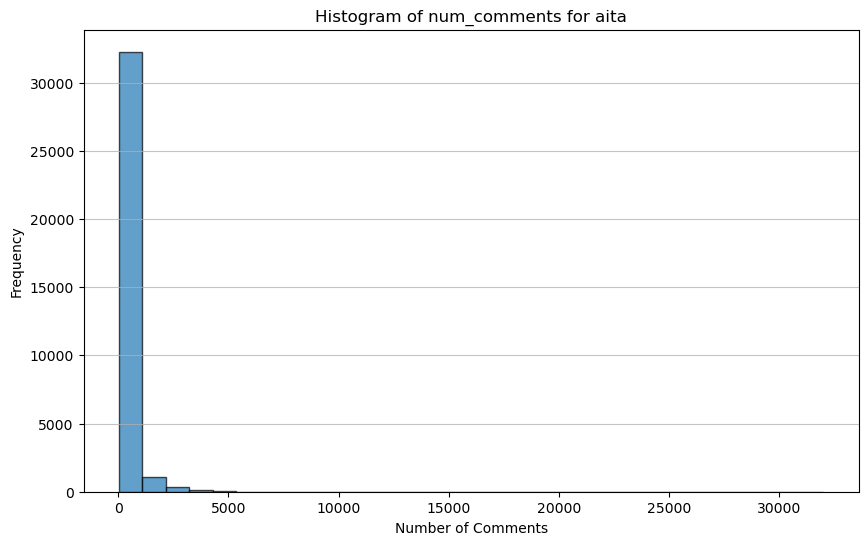

In [26]:
import matplotlib.pyplot as plt

# collect the num_comments data for aita
aita_num_comments = aita.select('num_comments').rdd.flatMap(lambda x: x).collect()

# histogram using matplotlib
plt.figure(figsize=(10, 6))
plt.hist(aita_num_comments, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of num_comments for aita')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

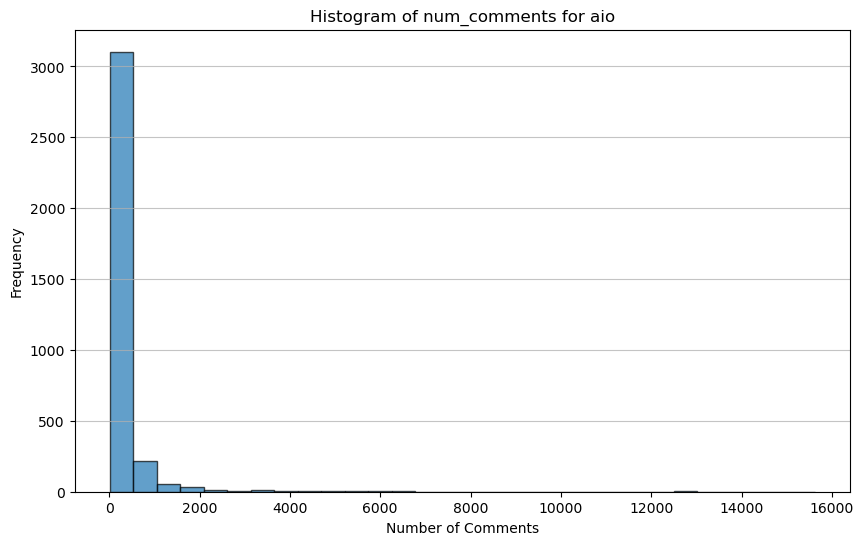

In [51]:
# aio
aio_num_comments = aio.select('num_comments').rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 6))
plt.hist(aio_num_comments, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of num_comments for aio')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

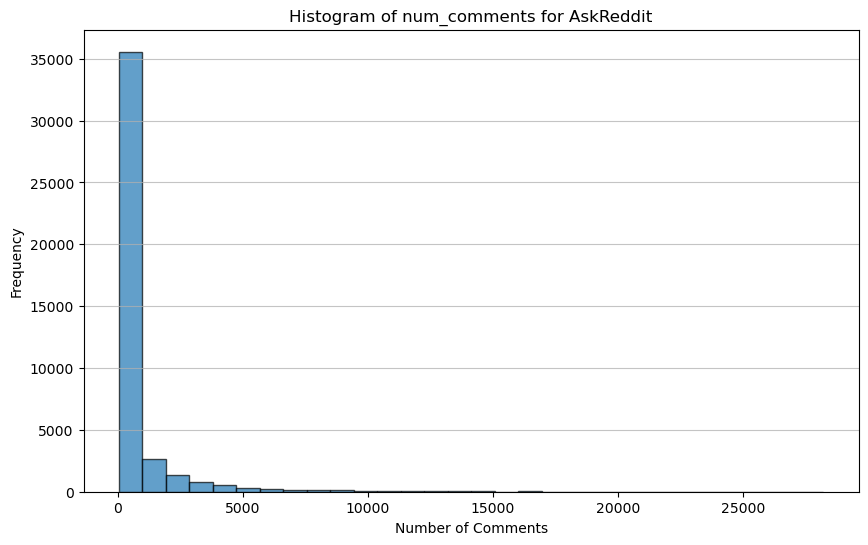

In [27]:
# ask reddit
ask_reddit_num_comments = ask_reddit.select('num_comments').rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 6))
plt.hist(ask_reddit_num_comments, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of num_comments for AskReddit')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

### Convert created_utc into readable datetime

In [28]:
from pyspark.sql.functions import from_unixtime, date_format, col

# Format the date
aita = aita.withColumn('created_date', date_format(from_unixtime(col('created_utc')), 'yyyy-MM-dd HH:mm:ss'))
aio = aio.withColumn('created_date', date_format(from_unixtime(col('created_utc')), 'yyyy-MM-dd HH:mm:ss'))
ask_reddit = ask_reddit.withColumn('created_date', date_format(from_unixtime(col('created_utc')), 'yyyy-MM-dd HH:mm:ss'))

In [29]:
aita.show(10)

+-------+-------------------+-----------+-------------+--------------------+--------------------+-----+------------+-------+-------------------+
|     id|             author|created_utc|    subreddit|               title|            selftext|score|num_comments|over_18|       created_date|
+-------+-------------------+-----------+-------------+--------------------+--------------------+-----+------------+-------+-------------------+
|14ck4v4|    Throwaway070511| 1687093840|AmItheAsshole|AITA for stepping...|I’ve never had mu...|  573|         171|  false|2023-06-18 13:10:40|
|14ckmm7|          BoboFF117| 1687095244|AmItheAsshole|AITA For Not Tech...|I will try to be ...|   13|          33|  false|2023-06-18 13:34:04|
|14cli3e|Peestainedbedsheets| 1687097589|AmItheAsshole|AITA for yelling ...|My wife and I jus...|  296|         151|  false|2023-06-18 14:13:09|
|14clm8b| ThrowawayLongdress| 1687097912|AmItheAsshole|AITA for showing ...|I (18f) sometimes...| 5374|         558|  false|2023-0

In [30]:
aio.show(10)

+-------+--------------------+-----------+---------------+--------------------+--------------------+-----+------------+-------+-------------------+
|     id|              author|created_utc|      subreddit|               title|            selftext|score|num_comments|over_18|       created_date|
+-------+--------------------+-----------+---------------+--------------------+--------------------+-----+------------+-------+-------------------+
|1c75wqv|Longjumping_Round637| 1713453455|AmIOverreacting|Should I cancel t...|Hello, I just fou...|  113|         294|  false|2024-04-18 15:17:35|
|1c76pzu|        LatterAd4096| 1713455446|AmIOverreacting|My granddaughter ...|\nMy oldest son t...|    0|          24|  false|2024-04-18 15:50:46|
|1c778ga|      Scared-Ad-7678| 1713456648|AmIOverreacting|Am I overreacting...|I’m 21 and he’s 3...|    1|          23|  false|2024-04-18 16:10:48|
|1c781ez|Various_Storage_9331| 1713458639|AmIOverreacting|I can’t get over ...|I[32F] have been ...|  403|      

In [31]:
ask_reddit.show(10)

+-------+--------------------+-----------+---------+--------------------+---------+-----+------------+-------+-------------------+
|     id|              author|created_utc|subreddit|               title| selftext|score|num_comments|over_18|       created_date|
+-------+--------------------+-----------+---------+--------------------+---------+-----+------------+-------+-------------------+
|14cjrit|  Flat-Succotash4784| 1687092820|AskReddit|what's your opini...|         |    0|          68|  false|2023-06-18 12:53:40|
|14ck18t|         BakerBrando| 1687093556|AskReddit|What are reasons ...|         |    1|          95|  false|2023-06-18 13:05:56|
|14ck8d2|MiserablePurpose5845| 1687094118|AskReddit|What is the one f...|         |   23|         135|  false|2023-06-18 13:15:18|
|14ck9np| Used-Equipment-5698| 1687094219|AskReddit|Non drinkers of R...|         |   11|          70|  false|2023-06-18 13:16:59|
|14ckmxj|         Ill-Ad-8421| 1687095268|AskReddit|What is the best ...|         |

### Create post_ids dataframe to join with comments (filtering out comments with no post)

In [32]:
# Create small DataFrames of post IDs for each filtered subreddit
aita_post_ids = aita.select('id').withColumnRenamed('id', 'post_id')
aio_post_ids = aio.select('id').withColumnRenamed('id', 'post_id')
ask_reddit_post_ids = ask_reddit.select('id').withColumnRenamed('id', 'post_id')

In [33]:
# union the post IDs from all subreddits
from pyspark.sql import DataFrame

post_ids = aita_post_ids.union(aio_post_ids).union(ask_reddit_post_ids)

# get the count of rows in the post_ids DataFrame
row_count = post_ids.count()
print(f"Number of rows in post_ids: {row_count}")

Number of rows in post_ids: 79602


<!-- ### Change column names to merge and differentiate from comments column -->

In [31]:
# sub_columns = sub_select.columns

# for col_name in sub_columns:
#     sub_select = sub_select.withColumnRenamed(col_name, f"sub_{col_name}")

# Comments

In [34]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_comments = "BDproject/comments/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"
#s3_path = "s3a://sagemaker-us-east-1-038932893404/project/comments/yyyy=2021/part-00000-90796409-5783-4705-92c0-27c27eda8c4c-c000.snappy.parquet"
print(f"reading comments from {s3_path}")
comments = spark.read.parquet(s3_path, header=True)
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")

reading comments from s3a://sagemaker-us-east-1-637423443621/BDproject/comments/yyyy=*


shape of the comments dataframe is 76,351,417x17
CPU times: user 582 ms, sys: 87.5 ms, total: 670 ms
Wall time: 4min 53s


In [35]:
# check counts (ensuring all needed subreddits exist)
comments.groupBy('subreddit').count().show()

+---------------+--------+
|      subreddit|   count|
+---------------+--------+
|      AskReddit|55851868|
|  AmItheAsshole|19472806|
|AmIOverreacting| 1026743|
+---------------+--------+



In [36]:
comments.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: double (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



### Select & Reorder Columns

In [37]:
# select and reorder columns
comments = comments.select(
    'id',
    'author',
    'link_id',
    'parent_id',
    'created_utc',
    'subreddit',
    'body',
    'score',
    'gilded',
    'controversiality'
)

comments.show(10)

+-------+--------------------+----------+----------+-----------+-------------+--------------------+-----+------+----------------+
|     id|              author|   link_id| parent_id|created_utc|    subreddit|                body|score|gilded|controversiality|
+-------+--------------------+----------+----------+-----------+-------------+--------------------+-----+------+----------------+
|jo488dx|  LeftandLeaving9006|t3_148x130|t3_148x130| 1686758855|    AskReddit|Anne of Green Gab...|    1|     0|               0|
|jo488e4|            daniboyi|t3_148nq2g|t1_jo1rnku| 1686758855|    AskReddit|as my dad always ...|    2|     0|               0|
|jo488eh|Fuck_you_Reddit_Nazi|t3_149b7c9|t1_jo47zcb| 1686758855|    AskReddit|Sounds like you n...|    3|     0|               0|
|jo488f4|Realistic-Active7230|t3_1498l3e|t3_1498l3e| 1686758855|AmItheAsshole|YTA! How spiteful...|    1|     0|               0|
|jo488g1|            An_Dr01d|t3_148sxkl|t3_148sxkl| 1686758856|    AskReddit|           K

### Remove comments that have body removed

In [38]:
# keep rows where body is not '[removed]'
comments = comments.filter(comments.body != '[removed]')

# check shape again
count = comments.count()
num_columns = len(comments.columns)
print(f"comments shape: ({count}, {num_columns})")

comments shape: (74619948, 10)


Comments: 76.35M -> 74.62M

### Filter to only keep comments with posts

In [39]:
post_ids.show(10)

+-------+
|post_id|
+-------+
|14ck4v4|
|14ckmm7|
|14cli3e|
|14clm8b|
|14clp5m|
|14clsxz|
|14cm0zy|
|14cmjqt|
|14cmzoz|
|14cn075|
+-------+
only showing top 10 rows



In [40]:
from pyspark.sql.functions import regexp_replace

# correctly format link_id for merge
comments = comments.withColumn("link_id", regexp_replace("link_id", "^[^_]+_", ""))

# also correctly format parent_id to evaluate how many top level comments there are 
comments = comments.withColumn("parent_id", regexp_replace("parent_id", "^[^_]+_", ""))

comments.show(10)

+-------+--------------------+-------+---------+-----------+-------------+--------------------+-----+------+----------------+
|     id|              author|link_id|parent_id|created_utc|    subreddit|                body|score|gilded|controversiality|
+-------+--------------------+-------+---------+-----------+-------------+--------------------+-----+------+----------------+
|jo488dx|  LeftandLeaving9006|148x130|  148x130| 1686758855|    AskReddit|Anne of Green Gab...|    1|     0|               0|
|jo488e4|            daniboyi|148nq2g|  jo1rnku| 1686758855|    AskReddit|as my dad always ...|    2|     0|               0|
|jo488eh|Fuck_you_Reddit_Nazi|149b7c9|  jo47zcb| 1686758855|    AskReddit|Sounds like you n...|    3|     0|               0|
|jo488f4|Realistic-Active7230|1498l3e|  1498l3e| 1686758855|AmItheAsshole|YTA! How spiteful...|    1|     0|               0|
|jo488g1|            An_Dr01d|148sxkl|  148sxkl| 1686758856|    AskReddit|           Kombucha.|    1|     0|          

In [45]:
# filter comments by performing an inner join with the post_ids DataFrame
comments_filtered = comments.join(post_ids, comments['link_id'] == post_ids['post_id'], how='inner')

# display the filtered comments
comments_filtered.show(10)

+-------+-------------------+-------+---------+-----------+---------+--------------------+-----+------+----------------+-------+
|     id|             author|link_id|parent_id|created_utc|subreddit|                body|score|gilded|controversiality|post_id|
+-------+-------------------+-------+---------+-----------+---------+--------------------+-----+------+----------------+-------+
|jo1701i| situationalreality|148kgyq|  148kgyq| 1686690154|AskReddit|My pardner just p...|    1|     0|               0|148kgyq|
|jo1cv1i|            onixdog|148kgyq|  148kgyq| 1686693179|AskReddit|Paper bouquet - Mili|    1|     0|               0|148kgyq|
|jo1du9d|woohooenjoyingspeed|148qus1|  148qus1| 1686693696|AskReddit|          Cigarettes|    2|     0|               0|148qus1|
|jo1dvms|          i-deology|148qus1|  148qus1| 1686693717|AskReddit|April 25. Not too...|   20|     0|               0|148qus1|
|jo1dwpq|        thanks_bruh|148qus1|  148qus1| 1686693733|AskReddit|Driving fast in a...|    1| 

In [46]:
%%time
# check shape again
count = comments_filtered.count()
num_columns = len(comments_filtered.columns)
print(f"comments shape: ({count}, {num_columns})")

comments shape: (39548046, 11)
CPU times: user 276 ms, sys: 37.1 ms, total: 313 ms
Wall time: 11min 14s


Comments: 76.35M -> 74.62M -> 39.54M


### Check for top level comments

In [47]:
# how many top-level comments are there?
top_level_comments_count = comments_filtered.filter(comments_filtered.link_id == comments_filtered.parent_id).count()
print(f"Number of top-level comments: {top_level_comments_count}")

Number of top-level comments: 20313289


In [49]:
from pyspark.sql.functions import when

# add a new column indicating whether the comment is a top-level comment (1 if True, 0 otherwise)
comments_filtered = comments_filtered.withColumn(
    "top_level_comment",
    when(comments_filtered.link_id == comments_filtered.parent_id, 1).otherwise(0)
)

comments_filtered.show(10)

+-------+-------------------+-------+---------+-----------+---------+--------------------+-----+------+----------------+-------+-----------------+
|     id|             author|link_id|parent_id|created_utc|subreddit|                body|score|gilded|controversiality|post_id|top_level_comment|
+-------+-------------------+-------+---------+-----------+---------+--------------------+-----+------+----------------+-------+-----------------+
|jo1701i| situationalreality|148kgyq|  148kgyq| 1686690154|AskReddit|My pardner just p...|    1|     0|               0|148kgyq|                1|
|jo1cv1i|            onixdog|148kgyq|  148kgyq| 1686693179|AskReddit|Paper bouquet - Mili|    1|     0|               0|148kgyq|                1|
|jo1du9d|woohooenjoyingspeed|148qus1|  148qus1| 1686693696|AskReddit|          Cigarettes|    2|     0|               0|148qus1|                1|
|jo1dvms|          i-deology|148qus1|  148qus1| 1686693717|AskReddit|April 25. Not too...|   20|     0|               

In [50]:
# filter the DataFrame to keep only rows where top_level_comment is 1
top_level_comments = comments_filtered.filter(comments_filtered.top_level_comment == 1)

# check shape again
count = top_level_comments.count()
num_columns = len(top_level_comments.columns)
print(f"comments shape: ({count}, {num_columns})")

comments shape: (20313289, 12)


In [ ]:
Comments: 76.35M -> 74.62M -> 39.54M -> 20.31M

### Convert created_utc into readable datetime

In [51]:
# format the date
top_level_comments = top_level_comments.withColumn('created_date_comment', date_format(from_unixtime(col('created_utc')), 'yyyy-MM-dd HH:mm:ss'))

top_level_comments.show(10)

+-------+-------------------+-------+---------+-----------+---------+--------------------+-----+------+----------------+-------+-----------------+--------------------+
|     id|             author|link_id|parent_id|created_utc|subreddit|                body|score|gilded|controversiality|post_id|top_level_comment|created_date_comment|
+-------+-------------------+-------+---------+-----------+---------+--------------------+-----+------+----------------+-------+-----------------+--------------------+
|jo1701i| situationalreality|148kgyq|  148kgyq| 1686690154|AskReddit|My pardner just p...|    1|     0|               0|148kgyq|                1| 2023-06-13 21:02:34|
|jo1cv1i|            onixdog|148kgyq|  148kgyq| 1686693179|AskReddit|Paper bouquet - Mili|    1|     0|               0|148kgyq|                1| 2023-06-13 21:52:59|
|jo1du9d|woohooenjoyingspeed|148qus1|  148qus1| 1686693696|AskReddit|          Cigarettes|    2|     0|               0|148qus1|                1| 2023-06-13 22

# Concatenate all post dataframes for eventual merge

In [52]:
# concatenate the DataFrames aita, aio, and ask_reddit into a single DataFrame posts
posts = aita.union(aio).union(ask_reddit)

posts.show(10)

+-------+-------------------+-----------+-------------+--------------------+--------------------+-----+------------+-------+-------------------+
|     id|             author|created_utc|    subreddit|               title|            selftext|score|num_comments|over_18|       created_date|
+-------+-------------------+-----------+-------------+--------------------+--------------------+-----+------------+-------+-------------------+
|14ck4v4|    Throwaway070511| 1687093840|AmItheAsshole|AITA for stepping...|I’ve never had mu...|  573|         171|  false|2023-06-18 13:10:40|
|14ckmm7|          BoboFF117| 1687095244|AmItheAsshole|AITA For Not Tech...|I will try to be ...|   13|          33|  false|2023-06-18 13:34:04|
|14cli3e|Peestainedbedsheets| 1687097589|AmItheAsshole|AITA for yelling ...|My wife and I jus...|  296|         151|  false|2023-06-18 14:13:09|
|14clm8b| ThrowawayLongdress| 1687097912|AmItheAsshole|AITA for showing ...|I (18f) sometimes...| 5374|         558|  false|2023-0

### rename variables before merge

In [53]:
# Rename columns in the top_level_comments DataFrame
top_level_comments = top_level_comments.withColumnRenamed("id", "comment_id") \
    .withColumnRenamed("author", "comment_author") \
    .withColumnRenamed("created_utc", "created_utc_comment") \
    .withColumnRenamed("subreddit", "subreddit_comment") \
    .withColumnRenamed("body", "comment_body") \
    .withColumnRenamed("score", "score_comment")

top_level_comments.show(10)

+----------+-------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-------+-----------------+--------------------+
|comment_id|     comment_author|link_id|parent_id|created_utc_comment|subreddit_comment|        comment_body|score_comment|gilded|controversiality|post_id|top_level_comment|created_date_comment|
+----------+-------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-------+-----------------+--------------------+
|   jo1701i| situationalreality|148kgyq|  148kgyq|         1686690154|        AskReddit|My pardner just p...|            1|     0|               0|148kgyq|                1| 2023-06-13 21:02:34|
|   jo1cv1i|            onixdog|148kgyq|  148kgyq|         1686693179|        AskReddit|Paper bouquet - Mili|            1|     0|               0|148kgyq|                1| 2023-06-13 21:52:59|
|   jo1du9d|woohooenjoyin

In [54]:
# Rename columns in the posts DataFrame
posts = posts.withColumnRenamed("id", "post_id") \
    .withColumnRenamed("author", "post_author") \
    .withColumnRenamed("created_utc", "created_utc_post") \
    .withColumnRenamed("subreddit", "subreddit_post") \
    .withColumnRenamed("title", "post_title") \
    .withColumnRenamed("score", "score_post") \
    .withColumnRenamed("created_date", "created_date_post")

posts.show(10)

+-------+-------------------+----------------+--------------+--------------------+--------------------+----------+------------+-------+-------------------+
|post_id|        post_author|created_utc_post|subreddit_post|          post_title|            selftext|score_post|num_comments|over_18|  created_date_post|
+-------+-------------------+----------------+--------------+--------------------+--------------------+----------+------------+-------+-------------------+
|14ck4v4|    Throwaway070511|      1687093840| AmItheAsshole|AITA for stepping...|I’ve never had mu...|       573|         171|  false|2023-06-18 13:10:40|
|14ckmm7|          BoboFF117|      1687095244| AmItheAsshole|AITA For Not Tech...|I will try to be ...|        13|          33|  false|2023-06-18 13:34:04|
|14cli3e|Peestainedbedsheets|      1687097589| AmItheAsshole|AITA for yelling ...|My wife and I jus...|       296|         151|  false|2023-06-18 14:13:09|
|14clm8b| ThrowawayLongdress|      1687097912| AmItheAsshole|AIT

### merge posts with top_level comments

In [55]:
merged_df = posts.join(top_level_comments, posts.post_id == top_level_comments.post_id, "inner")

merged_df.show(10)

+-------+-------------+----------------+--------------+--------------------+--------+----------+------------+-------+-------------------+----------+-------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-------+-----------------+--------------------+
|post_id|  post_author|created_utc_post|subreddit_post|          post_title|selftext|score_post|num_comments|over_18|  created_date_post|comment_id|     comment_author|link_id|parent_id|created_utc_comment|subreddit_comment|        comment_body|score_comment|gilded|controversiality|post_id|top_level_comment|created_date_comment|
+-------+-------------+----------------+--------------+--------------------+--------+----------+------------+-------+-------------------+----------+-------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-------+-----------------+--------------------+
|13xj9u

### create time_since_post variable

In [56]:
from pyspark.sql import functions as F

# calculate the time difference in hours between post and comment creation
merged_df = merged_df.withColumn(
    "time_since_post",
    (F.col("created_utc_comment") - F.col("created_utc_post")) / 3600
)

# display the first 10 rows to verify the new column
merged_df.show(10)

+-------+-------------+----------------+--------------+--------------------+--------+----------+------------+-------+-------------------+----------+-------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-------+-----------------+--------------------+--------------------+
|post_id|  post_author|created_utc_post|subreddit_post|          post_title|selftext|score_post|num_comments|over_18|  created_date_post|comment_id|     comment_author|link_id|parent_id|created_utc_comment|subreddit_comment|        comment_body|score_comment|gilded|controversiality|post_id|top_level_comment|created_date_comment|     time_since_post|
+-------+-------------+----------------+--------------+--------------------+--------+----------+------------+-------+-------------------+----------+-------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-------+-----

### filter out comments with time_since_post greater than 24hr

In [59]:
# filter out rows where comments occurred more than 24 hours after post creation
merged_df = merged_df.filter(F.col("time_since_post") <= 24)

# display the first few rows to verify the filtered results
merged_df.show(10)

+-------+-------------+----------------+--------------+--------------------+--------+----------+------------+-------+-------------------+----------+-------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-------+-----------------+--------------------+--------------------+
|post_id|  post_author|created_utc_post|subreddit_post|          post_title|selftext|score_post|num_comments|over_18|  created_date_post|comment_id|     comment_author|link_id|parent_id|created_utc_comment|subreddit_comment|        comment_body|score_comment|gilded|controversiality|post_id|top_level_comment|created_date_comment|     time_since_post|
+-------+-------------+----------------+--------------+--------------------+--------+----------+------------+-------+-------------------+----------+-------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-------+-----

In [61]:
# round time_since_post to five decimal places
merged_df = merged_df.withColumn("time_since_post", F.round(F.col("time_since_post"), 5))

In [62]:
merged_df.show(10)

+-------+-------------+----------------+--------------+--------------------+--------+----------+------------+-------+-------------------+----------+-------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-------+-----------------+--------------------+---------------+
|post_id|  post_author|created_utc_post|subreddit_post|          post_title|selftext|score_post|num_comments|over_18|  created_date_post|comment_id|     comment_author|link_id|parent_id|created_utc_comment|subreddit_comment|        comment_body|score_comment|gilded|controversiality|post_id|top_level_comment|created_date_comment|time_since_post|
+-------+-------------+----------------+--------------+--------------------+--------+----------+------------+-------+-------------------+----------+-------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-------+---------------

In [63]:
# check shape again
count = merged_df.count()
num_columns = len(merged_df.columns)
print(f"comments shape: ({count}, {num_columns})")

comments shape: (19293439, 24)


Comments: 76.35M -> 74.62M -> 39.54M -> 20.31M -> 19.29M

### separate by subreddit

In [ ]:
# Drop the duplicate column (if needed)
merged_df = merged_df.drop(top_level_comments.post_id)

# filter and create separate dataframes
aita = merged_df.filter(merged_df['subreddit_post'] == 'AmItheAsshole')
aio = merged_df.filter(merged_df['subreddit_post'] == 'AmIOverreacting')
ask_reddit = merged_df.filter(merged_df['subreddit_post'] == 'AskReddit')

# print shapes of each subreddit
aita_count = aita.count()
aita_columns = len(aita.columns)
print(f"aita shape: ({aita_count}, {aita_columns})")

aio_count = aio.count()
aio_columns = len(aio.columns)
print(f"aio shape: ({aio_count}, {aio_columns})")

ask_reddit_count = ask_reddit.count()
ask_reddit_columns = len(ask_reddit.columns)
print(f"AskReddit shape: ({ask_reddit_count}, {ask_reddit_columns})")

# print shapes of posts
posts_count = posts.count()
posts_columns = len(posts.columns)
print(f"Posts shape: ({posts_count}, {posts_columns})")

aita shape: (3955392, 23)


aio shape: (474575, 23)


### save files

In [ ]:
# set up S3 paths
aita_path = f"s3a://{bucket}/BDproject/aita.parquet"
aio_path = f"s3a://{bucket}/BDproject/aio.parquet"
ask_reddit_path = f"s3a://{bucket}/BDproject/ask_reddit.parquet"
posts_path = f"s3a://{bucket}/BDproject/posts.parquet"


# save the DataFrames as Parquet files to S3
aita.write.mode('overwrite').parquet(aita_path)
aio.write.mode('overwrite').parquet(aio_path)
ask_reddit.write.mode('overwrite').parquet(ask_reddit_path)
posts.write.mode('overwrite').parquet(posts_path)

<!-- ### Separating by subreddit -->

In [ ]:
# # filter and create separate dataframes
# aita_comments = comments_filtered.filter(comments_filtered['subreddit'] == 'AmItheAsshole')
# aio_comments = comments_filtered.filter(comments_filtered['subreddit'] == 'AmIOverreacting')
# ask_reddit_comments = comments_filtered.filter(comments_filtered['subreddit'] == 'AskReddit')

# # print initial shapes of each subreddit
# aita_count = aita_comments.count()
# aita_columns = len(aita_comments.columns)
# print(f"aita shape: ({aita_count}, {aita_columns})")

# aio_count = aio_comments.count()
# aio_columns = len(aio_comments.columns)
# print(f"aio shape: ({aio_count}, {aio_columns})")

# ask_reddit_count = ask_reddit_comments.count()
# ask_reddit_columns = len(ask_reddit_comments.columns)
# print(f"AskReddit shape: ({ask_reddit_count}, {ask_reddit_columns})")

<!-- AITA: 8.21M comments<br></br>
AIO: 989k comments<br></br>
TIFU: 664k comments -->

<!-- ### Convert created_utc into readable datetime -->

In [ ]:
# # Format the date
# aita_comments = aita_comments.withColumn('created_date', date_format(from_unixtime(col('created_utc')), 'yyyy-MM-dd HH:mm:ss'))
# aio_comments = aio_comments.withColumn('created_date', date_format(from_unixtime(col('created_utc')), 'yyyy-MM-dd HH:mm:ss'))
# ask_reddit_comments = ask_reddit_comments.withColumn('created_date', date_format(from_unixtime(col('created_utc')), 'yyyy-MM-dd HH:mm:ss'))

# # let's take a look at aita_comments
# aita_comments.show(10)

<!-- # Save Files -->

In [ ]:
# # set up S3 paths
# aita_path = f"s3a://{bucket}/BDproject/aita.parquet"
# aio_path = f"s3a://{bucket}/BDproject/aio.parquet"
# ask_reddit_path = f"s3a://{bucket}/BDproject/ask_reddit.parquet"
# aita_comments_path = f"s3a://{bucket}/BDproject/aita_comments.parquet"
# aio_comments_path = f"s3a://{bucket}/BDproject/aio_comments.parquet"
# ask_reddit_comments_path = f"s3a://{bucket}/BDproject/ask_reddit_comments.parquet"


# # save the DataFrames as Parquet files to S3
# aita.write.mode('overwrite').parquet(aita_path)
# aio.write.mode('overwrite').parquet(aio_path)
# ask_reddit.write.mode('overwrite').parquet(ask_reddit_path)
# aita_comments.write.mode('overwrite').parquet(aita_comments_path)
# aio_comments.write.mode('overwrite').parquet(aio_comments_path)
# ask_reddit_comments.write.mode('overwrite').parquet(ask_reddit_comments_path)

<!-- # START HERE: LOAD IN FILES

steps remaining: create column comment_level, rename some columns to avoid confusion during merge, merge, remove comments created more than a certain amount of time after post creation -->

In [ ]:
# import sagemaker
# session = sagemaker.Session()
# bucket = session.default_bucket()

In [ ]:
# # set up S3 paths
# aita_path = f"s3a://{bucket}/project_preprocess/aita.parquet"
# aio_path = f"s3a://{bucket}/project_preprocess/aio.parquet"
# ask_reddit_path = f"s3a://{bucket}/project_preprocess/ask_reddit.parquet"
# aita_comments_path = f"s3a://{bucket}/project_preprocess/aita_comments.parquet"
# aio_comments_path = f"s3a://{bucket}/project_preprocess/aio_comments.parquet"
# ask_reddit_comments_path = f"s3a://{bucket}/project_preprocess/ask_reddit_comments.parquet"


# # Read the Parquet files from S3
# aita_df = spark.read.parquet(aita_path)
# aio_df = spark.read.parquet(aio_path)
# ask_reddit_df = spark.read.parquet(ask_reddit_path)
# aita_comments_df = spark.read.parquet(aita_comments_path)
# aio_comments_df = spark.read.parquet(aio_comments_path)
# ask_reddit_comments_df = spark.read.parquet(ask_reddit_comments_path)

# # Show headers with 5 rows for each DataFrame
# print("AITA DataFrame")
# aita_df.show(5)

# print("AIO DataFrame")
# aio_df.show(5)

# print("Ask Reddit DataFrame")
# ask_reddit_df.show(5)

# print("AITA Comments DataFrame")
# aita_comments_df.show(5)

# print("AIO Comments DataFrame")
# aio_comments_df.show(5)

# print("Ask Reddit Comments DataFrame")
# ask_reddit_comments_df.show(5)

In [ ]:
# Show schemas
print("AITA DataFrame")
aita_df.printSchema()

print("AIO DataFrame")
aio_df.printSchema()

print("Ask Reddit DataFrame")
ask_reddit_df.printSchema()

print("AITA Comments DataFrame")
aita_comments_df.printSchema()

print("AIO Comments DataFrame")
aio_comments_df.printSchema()

print("Ask Reddit Comments DataFrame")
ask_reddit_comments_df.printSchema()


In [ ]:
# # Prepare for parent id matching
# from pyspark.sql.functions import regexp_replace

# aita_comments_df = aita_comments_df.withColumn("parent_id", regexp_replace("parent_id", "^[^_]+_", ""))
# aio_comments_df = aio_comments_df.withColumn("parent_id", regexp_replace("parent_id", "^[^_]+_", ""))
# ask_reddit_comments_df = ask_reddit_comments_df.withColumn("parent_id", regexp_replace("parent_id", "^[^_]+_", ""))


In [ ]:
# from pyspark.sql import functions as F

# def filter_comments_to_level_1(submissions_df, comments_df):
#     """
#     Adds a comment_level column to the comments DataFrame and filters to only keep comment_level=1,
#     where the parent_id in the comments matches an id in the submissions DataFrame.
    
#     Parameters:
#         submissions_df (DataFrame): The submissions DataFrame (aita, aio, ask_reddit)
#         comments_df (DataFrame): The comments DataFrame (aita_comments, aio_comments, ask_reddit_comments)
    
#     Returns:
#         DataFrame: Filtered comments DataFrame with only level 1 comments.
#     """
#     # Create the comment_level column by checking if parent_id matches id in submissions DataFrame
#     comments_df_with_level = comments_df.withColumn(
#         "comment_level",
#         F.when(comments_df["parent_id"].isin(submissions_df.select("id").rdd.flatMap(lambda x: x).collect()), 1).otherwise(0)
#     )
    
#     # Filter to keep only comments with comment_level=1
#     comments_level_1 = comments_df_with_level.filter(comments_df_with_level["comment_level"] == 1)
    
#     return comments_level_1

# aita_comments_df = filter_comments_to_level_1(aita_df, aita_comments_df)
# aio_comments_df = filter_comments_to_level_1(aio_df, aio_comments_df)
# ask_reddit_comments_df = filter_comments_to_level_1(ask_reddit_df, ask_reddit_comments_df)


# aita_comments_df.show(5)
# aio_comments_df.show(5)
# ask_reddit_comments_df.show(5)

In [ ]:
# # Merging

# def merge_submission_with_comments(submissions_df, comments_df):
#     """
#     Merges a submission DataFrame with its corresponding comments DataFrame based on the id -> link_id relationship.
#     Renames columns in the comments DataFrame by adding a "_comments" suffix to avoid conflicts.
    
#     Parameters:
#         submissions_df (DataFrame): The submissions DataFrame (e.g., aita, aio, ask_reddit).
#         comments_df (DataFrame): The comments DataFrame (e.g., aita_comments, aio_comments, ask_reddit_comments).
    
#     Returns:
#         DataFrame: Merged DataFrame.
#     """
#     # Rename columns in the comments DataFrame by adding a "_comments" suffix
#     comments_renamed = comments_df.select([F.col(c).alias(f"{c}_comments") for c in comments_df.columns])
    
#     # Perform the join using submissions_df.id and comments_df.link_id (renamed to link_id_comments)
#     merged_df = submissions_df.join(comments_renamed, submissions_df.id == comments_renamed.link_id_comments, "inner")
    
#     return merged_df

# # Example usage for each pair of submission and comments DataFrames
# aita_merged = merge_submission_with_comments(aita_df, aita_comments_df)
# aio_merged = merge_submission_with_comments(aio_df, aio_comments_df)
# ask_reddit_merged = merge_submission_with_comments(ask_reddit_df, ask_reddit_comments_df)

# # Show the first 5 rows of each merged DataFrame
# aita_merged.show(5)
# aio_merged.show(5)
# ask_reddit_merged.show(5)

In [ ]:
# # Comments clipping

# def filter_comments_by_time_difference(merged_df, hours_threshold=72):
#     """
#     Filters comments from a merged DataFrame to retain only those created within a specified number of hours
#     after the submission post was created.
    
#     Parameters:
#         merged_df (DataFrame): The merged DataFrame containing submission and comments data.
#         hours_threshold (int): The maximum number of hours allowed between post and comment creation. Default is 72 hours.
    
#     Returns:
#         DataFrame: Filtered DataFrame with only comments created within the specified time after the post.
#     """
#     # Calculate the time difference in hours between post and comment creation
#     time_difference_in_hours = (F.col("created_utc_comments") - F.col("created_utc")) / 3600

#     # Filter comments based on the hours threshold
#     filtered_df = merged_df.filter(time_difference_in_hours <= hours_threshold)
    
#     return filtered_df

# aita_filtered = filter_comments_by_time_difference(aita_merged)
# aio_filtered = filter_comments_by_time_difference(aio_merged)
# ask_reddit_filtered = filter_comments_by_time_difference(ask_reddit_merged)

# aita_filtered.show(5)
# aio_filtered.show(5)
# ask_reddit_filtered.show(5)

In [ ]:
# def get_dataframe_shape(df, name):
#     """
#     Returns the shape of the given DataFrame.
    
#     Parameters:
#         df (DataFrame): The DataFrame to evaluate.
#         name (str): The name of the DataFrame.
    
#     Returns:
#         tuple: Shape of the DataFrame (number of rows, number of columns).
#     """
#     num_rows = df.count()
#     num_columns = len(df.columns)
#     print(f"{name} Shape: ({num_rows}, {num_columns})")
#     return num_rows, num_columns


# aita_shape = get_dataframe_shape(aita_filtered, "AITA Filtered")
# aio_shape = get_dataframe_shape(aio_filtered, "AIO Filtered")
# ask_reddit_shape = get_dataframe_shape(ask_reddit_filtered, "Ask Reddit Filtered")

In [ ]:
# aita_filtered.printSchema()

In [ ]:
# # Save Files
# # set up S3 paths
# aita_filtered_path = f"s3a://{bucket}/project/aita.parquet"
# aio_filtered_path = f"s3a://{bucket}/project/aio.parquet"
# ask_reddit_filtered_path = f"s3a://{bucket}/project/ask_reddit.parquet"


# # save the DataFrames as Parquet files to S3
# aita_filtered.write.mode('overwrite').parquet(aita_filtered_path)
# aio_filtered.write.mode('overwrite').parquet(aio_filtered_path)
# ask_reddit_filtered.write.mode('overwrite').parquet(ask_reddit_filtered_path)

<!-- ---------------
# Legacy -->

<!-- ### Preprocess ID on comments data for merge
 - comments data link_suffix connects with submissions id.
 - if parent_suffix = link_suffix its the 'parent' comment.
 - if parent_suffix != linke_suffix its a comment within a comment -->

In [ ]:
from pyspark.sql.functions import split

comments_filter = comments \
    .withColumn("link_prefix", split(comments["link_id"], "_").getItem(0)) \
    .withColumn("link_suffix", split(comments["link_id"], "_").getItem(1)) \
    .withColumn("parent_prefix", split(comments["parent_id"], "_").getItem(0)) \
    .withColumn("parent_suffix", split(comments["parent_id"], "_").getItem(1))

In [ ]:
comments_filter.show()

In [ ]:
# Check Merging columns
result = comments_filter.filter(comments_filter.link_suffix == "15jq1rq")
result.show()

<!-- ### Remove rows that have text removed -->

In [ ]:
comm_clean = comments_filter.filter(comments_filter.body != '[removed]')

In [ ]:
comm_clean.count()

<!-- ### Only select columns that will be used -->

In [ ]:
comm_select = comm_clean.select("author","body","controversiality","created_utc","id","link_suffix","parent_suffix","subreddit","score")

<!-- ### Change column names so  -->

In [ ]:
columns = comm_select.columns

for col_name in columns:
    comm_select = comm_select.withColumnRenamed(col_name, f"com_{col_name}")

<!-- ## Merge Comments and Submissions -->

In [ ]:
# merged_df = sub_select.join(comm_select, sub_select.sub_id == comm_select.com_link_suffix, "left")


In [ ]:
# merged_df.show(5)

<!-- ### Change UTC to date -->

In [ ]:
# from pyspark.sql.functions import from_unixtime, col

In [ ]:
# merged_df = merged_df.withColumn("sub_created_date", from_unixtime(col("sub_created_utc")).cast("date"))\
#                     .withColumn("com_created_date", from_unixtime(col("com_created_utc")).cast("date"))



In [ ]:
# merged_df.show(5)